In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import torch
import pandas as pd
from torch import nn
from torch.nn import functional as F
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import wandb

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import gc
torch.cuda.empty_cache()
gc.collect()

60

In [4]:
!wandb login

wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


In [9]:
#Random seed
torch.manual_seed(42)
if torch.cuda.is_available():
    print("Cuda is available")
    torch.cuda.manual_seed_all(42)  # For all GPUs

Cuda is available


# Load Dataset

In [10]:
SpookyTrain = pd.read_csv('Data/spooky-author-identification/train.csv')
#SpookyTest = pd.read_csv('Data/spooky-author-identification/test.csv')

SpookyTrain.head()
#SpookyTest.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


# Prepare Tokenizer and Data preprocess

In [11]:
label_encoder = LabelEncoder()
SpookyTrain['author_label'] = label_encoder.fit_transform(SpookyTrain['author'])

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [38]:
def preprocess_function(train_df):
    tokenized_output = tokenizer(train_df["text"], truncation=True)

    return {
        'input_ids': tokenized_output['input_ids'],
        'attention_mask': tokenized_output['attention_mask'],
        'labels': train_df["author_label"]
    }

In [14]:
tokened_dictionary = SpookyTrain.apply(preprocess_function, axis=1, result_type = 'expand')

In [15]:
print(tokened_dictionary)
print(SpookyTrain)

                                               input_ids  \
0      [101, 2023, 2832, 1010, 2174, 1010, 22891, 203...   
1      [101, 2009, 2196, 2320, 4158, 2000, 2033, 2008...   
2      [101, 1999, 2010, 2187, 2192, 2001, 1037, 2751...   
3      [101, 2129, 8403, 2003, 3500, 2004, 2057, 2246...   
4      [101, 4531, 2498, 2842, 1010, 2025, 2130, 2751...   
...                                                  ...   
19574  [101, 1045, 2071, 2031, 5470, 23402, 2094, 101...   
19575  [101, 1996, 26122, 8555, 3209, 2362, 2004, 206...   
19576  [101, 14736, 2015, 6335, 6904, 4904, 12943, 43...   
19577  [101, 2005, 2019, 8875, 1997, 2739, 2066, 2023...   
19578  [101, 2002, 4201, 1037, 1043, 11802, 3709, 150...   

                                          attention_mask  labels  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0  
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       1  
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0  
3      [1, 

In [16]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(tokened_dictionary, test_size=0.1, stratify=SpookyTrain["author"],random_state=42) #due to we want to have 10 cross vals

In [17]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
#Pad the data with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Prepare Evaluation

In [19]:
accuracy = evaluate.load("accuracy")

In [20]:
id2label = {0: "EAP", 1: "HPL", 2: "MWS"}
label2id = {"EAP": 0, "HPL": 1, "MWS": 2}

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
def compute_metrics_complete(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'balanced_accuracy': balanced_accuracy_score(labels, predictions)
    }

# Load Model and Encoding: Distill BERT

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start Training

In [26]:
training_args = TrainingArguments(
    output_dir="./HuggingFace_SavedModel/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="wandb",
    run_name="DistillBERT_lr2emin5_epoch4_batch16",  # Name of the wandb run
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [27]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


 11%|█▏        | 501/4408 [00:44<05:22, 12.11it/s]

{'loss': 0.816, 'learning_rate': 2e-05, 'epoch': 0.45}


 23%|██▎       | 1001/4408 [01:38<05:26, 10.42it/s]

{'loss': 0.4904, 'learning_rate': 1.7441146366427843e-05, 'epoch': 0.91}


                                                   
 25%|██▌       | 1102/4408 [01:51<05:04, 10.86it/s]

{'eval_loss': 0.3902754485607147, 'eval_accuracy': 0.8416751787538305, 'eval_runtime': 3.5216, 'eval_samples_per_second': 555.996, 'eval_steps_per_second': 34.927, 'epoch': 1.0}


 34%|███▍      | 1502/4408 [02:33<04:20, 11.14it/s]

{'loss': 0.3279, 'learning_rate': 1.488229273285568e-05, 'epoch': 1.36}


 45%|████▌     | 2002/4408 [03:25<03:37, 11.06it/s]

{'loss': 0.279, 'learning_rate': 1.2323439099283523e-05, 'epoch': 1.81}


                                                   
 50%|█████     | 2204/4408 [03:48<04:00,  9.18it/s]

{'eval_loss': 0.37748289108276367, 'eval_accuracy': 0.86414708886619, 'eval_runtime': 3.6524, 'eval_samples_per_second': 536.093, 'eval_steps_per_second': 33.677, 'epoch': 2.0}


 57%|█████▋    | 2502/4408 [04:20<03:07, 10.18it/s]

{'loss': 0.2002, 'learning_rate': 9.764585465711363e-06, 'epoch': 2.27}


 68%|██████▊   | 3001/4408 [05:12<02:37,  8.93it/s]

{'loss': 0.153, 'learning_rate': 7.205731832139202e-06, 'epoch': 2.72}


                                                   
 75%|███████▌  | 3306/4408 [05:48<01:43, 10.60it/s]

{'eval_loss': 0.5496595501899719, 'eval_accuracy': 0.8559754851889684, 'eval_runtime': 3.7116, 'eval_samples_per_second': 527.533, 'eval_steps_per_second': 33.139, 'epoch': 3.0}


 79%|███████▉  | 3501/4408 [06:08<01:28, 10.23it/s]

{'loss': 0.12, 'learning_rate': 4.646878198567042e-06, 'epoch': 3.18}


 91%|█████████ | 4002/4408 [07:02<00:38, 10.58it/s]

{'loss': 0.079, 'learning_rate': 2.0880245649948825e-06, 'epoch': 3.63}


                                                   
100%|██████████| 4408/4408 [07:50<00:00, 10.61it/s]

{'eval_loss': 0.5363865494728088, 'eval_accuracy': 0.8733401430030644, 'eval_runtime': 3.7116, 'eval_samples_per_second': 527.533, 'eval_steps_per_second': 33.139, 'epoch': 4.0}


100%|██████████| 4408/4408 [07:51<00:00,  9.34it/s]

{'train_runtime': 474.6435, 'train_samples_per_second': 148.499, 'train_steps_per_second': 9.287, 'train_loss': 0.2858874391081545, 'epoch': 4.0}


TrainOutput(global_step=4408, training_loss=0.2858874391081545, metrics={'train_runtime': 474.6435, 'train_samples_per_second': 148.499, 'train_steps_per_second': 9.287, 'train_loss': 0.2858874391081545, 'epoch': 4.0})

Save model and tokenizer

In [29]:
model.save_pretrained('HuggingFace_SavedModel/DistillBERT_lr2emin5_epoch4_batch16/')
tokenizer.save_pretrained('HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/')

('HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/tokenizer_config.json',
 'HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/special_tokens_map.json',
 'HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/vocab.txt',
 'HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/added_tokens.json',
 'HuggingFace_SavedModel/DistillBERTTokenizer_lr2emin5_epoch4_batch16/tokenizer.json')

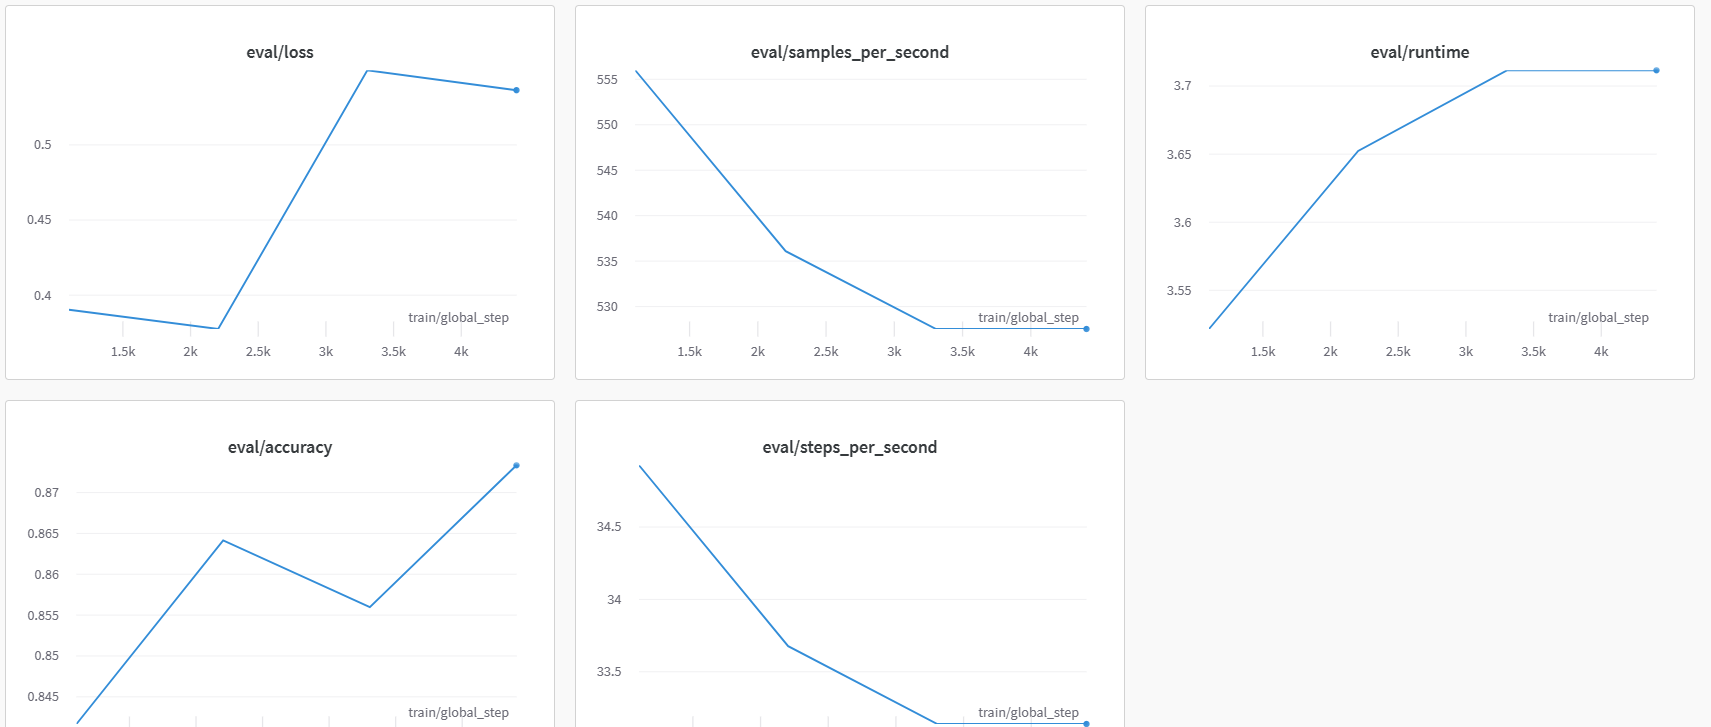

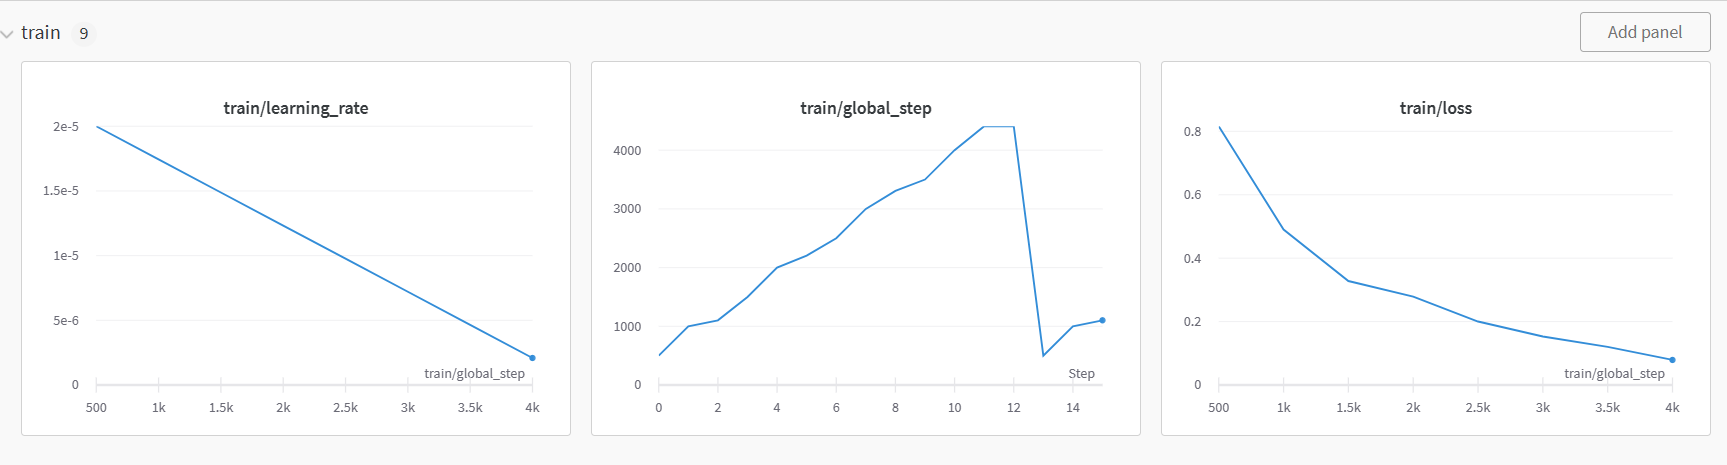

Eval Accuracy reach 0.87 and keeps on rising after 4 iteration, try again by increasing the epochs (to 10)

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
training_args = TrainingArguments(
    output_dir="./HuggingFace_SavedModel/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="wandb",
    run_name="DistillBERT_lr2emin5_epoch4_batch16",  # Name of the wandb run
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

  5%|▍         | 502/11020 [00:44<15:13, 11.52it/s]

{'loss': 0.821, 'learning_rate': 2e-05, 'epoch': 0.45}


  9%|▉         | 1002/11020 [01:39<16:39, 10.02it/s] 

{'loss': 0.4887, 'learning_rate': 1.9049429657794677e-05, 'epoch': 0.91}


                                                    
 10%|█         | 1102/11020 [01:52<13:45, 12.02it/s]

{'eval_loss': 0.3962559401988983, 'eval_accuracy': 0.8432073544433095, 'eval_runtime': 3.673, 'eval_samples_per_second': 533.079, 'eval_steps_per_second': 33.488, 'epoch': 1.0}


 14%|█▎        | 1502/11020 [02:36<14:30, 10.93it/s]  

{'loss': 0.3323, 'learning_rate': 1.8098859315589353e-05, 'epoch': 1.36}


 18%|█▊        | 2001/11020 [03:30<14:19, 10.49it/s]  

{'loss': 0.29, 'learning_rate': 1.7148288973384032e-05, 'epoch': 1.81}


                                                    
 20%|██        | 2204/11020 [03:53<16:33,  8.87it/s]

{'eval_loss': 0.39568668603897095, 'eval_accuracy': 0.8595505617977528, 'eval_runtime': 3.6905, 'eval_samples_per_second': 530.554, 'eval_steps_per_second': 33.329, 'epoch': 2.0}


 23%|██▎       | 2502/11020 [04:26<13:49, 10.27it/s]  

{'loss': 0.2046, 'learning_rate': 1.6197718631178708e-05, 'epoch': 2.27}


 27%|██▋       | 3001/11020 [05:18<14:52,  8.98it/s]

{'loss': 0.1539, 'learning_rate': 1.5247148288973386e-05, 'epoch': 2.72}


                                                    
 30%|███       | 3306/11020 [05:54<12:28, 10.30it/s]

{'eval_loss': 0.5411470532417297, 'eval_accuracy': 0.8544433094994893, 'eval_runtime': 3.6963, 'eval_samples_per_second': 529.723, 'eval_steps_per_second': 33.277, 'epoch': 3.0}


 32%|███▏      | 3501/11020 [06:14<12:16, 10.21it/s]  

{'loss': 0.1285, 'learning_rate': 1.4296577946768061e-05, 'epoch': 3.18}


 36%|███▋      | 4002/11020 [07:08<11:04, 10.56it/s]

{'loss': 0.088, 'learning_rate': 1.3346007604562739e-05, 'epoch': 3.63}


                                                    
 40%|████      | 4408/11020 [07:55<10:18, 10.68it/s]

{'eval_loss': 0.6249750852584839, 'eval_accuracy': 0.872829417773238, 'eval_runtime': 3.6863, 'eval_samples_per_second': 531.162, 'eval_steps_per_second': 33.367, 'epoch': 4.0}


 41%|████      | 4502/11020 [08:06<10:45, 10.09it/s]  

{'loss': 0.0669, 'learning_rate': 1.2395437262357415e-05, 'epoch': 4.08}


 45%|████▌     | 5002/11020 [08:59<09:44, 10.30it/s]  

{'loss': 0.0374, 'learning_rate': 1.144486692015209e-05, 'epoch': 4.54}


 50%|████▉     | 5502/11020 [09:53<09:01, 10.19it/s]

{'loss': 0.0426, 'learning_rate': 1.049429657794677e-05, 'epoch': 4.99}


                                                    
 50%|█████     | 5510/11020 [09:58<08:23, 10.93it/s]

{'eval_loss': 0.7969400882720947, 'eval_accuracy': 0.8636363636363636, 'eval_runtime': 3.7007, 'eval_samples_per_second': 529.084, 'eval_steps_per_second': 33.237, 'epoch': 5.0}


 54%|█████▍    | 6000/11020 [10:52<07:35, 11.03it/s]  

{'loss': 0.0223, 'learning_rate': 9.543726235741445e-06, 'epoch': 5.44}


 59%|█████▉    | 6501/11020 [11:44<07:03, 10.67it/s]

{'loss': 0.0195, 'learning_rate': 8.593155893536123e-06, 'epoch': 5.9}


                                                    
 60%|██████    | 6612/11020 [11:59<06:35, 11.15it/s]

{'eval_loss': 0.8203399181365967, 'eval_accuracy': 0.8820224719101124, 'eval_runtime': 3.6845, 'eval_samples_per_second': 531.419, 'eval_steps_per_second': 33.383, 'epoch': 6.0}


 64%|██████▎   | 7001/11020 [12:41<07:13,  9.27it/s]

{'loss': 0.013, 'learning_rate': 7.642585551330799e-06, 'epoch': 6.35}


 68%|██████▊   | 7500/11020 [13:35<05:42, 10.27it/s]

{'loss': 0.0122, 'learning_rate': 6.692015209125475e-06, 'epoch': 6.81}


                                                    
 70%|███████   | 7714/11020 [14:01<04:54, 11.23it/s]

{'eval_loss': 0.8911228775978088, 'eval_accuracy': 0.881511746680286, 'eval_runtime': 3.6817, 'eval_samples_per_second': 531.82, 'eval_steps_per_second': 33.409, 'epoch': 7.0}


 73%|███████▎  | 8001/11020 [14:36<04:58, 10.13it/s]

{'loss': 0.009, 'learning_rate': 5.741444866920153e-06, 'epoch': 7.26}


 77%|███████▋  | 8502/11020 [15:27<04:02, 10.37it/s]

{'loss': 0.0081, 'learning_rate': 4.790874524714829e-06, 'epoch': 7.71}


                                                    
 80%|████████  | 8816/11020 [16:04<03:26, 10.68it/s]

{'eval_loss': 0.9461458325386047, 'eval_accuracy': 0.8810010214504597, 'eval_runtime': 3.697, 'eval_samples_per_second': 529.612, 'eval_steps_per_second': 33.27, 'epoch': 8.0}


 82%|████████▏ | 9002/11020 [16:26<03:15, 10.32it/s]

{'loss': 0.0106, 'learning_rate': 3.840304182509506e-06, 'epoch': 8.17}


 86%|████████▌ | 9502/11020 [17:19<02:13, 11.38it/s]

{'loss': 0.0029, 'learning_rate': 2.8897338403041826e-06, 'epoch': 8.62}


                                                    
 90%|█████████ | 9918/11020 [18:07<01:39, 11.13it/s]

{'eval_loss': 1.0594428777694702, 'eval_accuracy': 0.874361593462717, 'eval_runtime': 3.6942, 'eval_samples_per_second': 530.016, 'eval_steps_per_second': 33.295, 'epoch': 9.0}


 91%|█████████ | 10002/11020 [18:17<01:33, 10.89it/s]

{'loss': 0.0037, 'learning_rate': 1.9391634980988593e-06, 'epoch': 9.07}


 95%|█████████▌| 10500/11020 [19:11<00:51, 10.01it/s]

{'loss': 0.0018, 'learning_rate': 9.885931558935361e-07, 'epoch': 9.53}


100%|█████████▉| 11001/11020 [20:05<00:01, 10.12it/s]

{'loss': 0.0017, 'learning_rate': 3.802281368821293e-08, 'epoch': 9.98}


                                                     
100%|██████████| 11020/11020 [20:10<00:00,  9.52it/s]

{'eval_loss': 0.9982917308807373, 'eval_accuracy': 0.8784473953013279, 'eval_runtime': 3.7197, 'eval_samples_per_second': 526.389, 'eval_steps_per_second': 33.067, 'epoch': 10.0}


100%|██████████| 11020/11020 [20:12<00:00,  9.09it/s]

{'train_runtime': 1212.8488, 'train_samples_per_second': 145.286, 'train_steps_per_second': 9.086, 'train_loss': 0.12516349920878433, 'epoch': 10.0}


TrainOutput(global_step=11020, training_loss=0.12516349920878433, metrics={'train_runtime': 1212.8488, 'train_samples_per_second': 145.286, 'train_steps_per_second': 9.086, 'train_loss': 0.12516349920878433, 'epoch': 10.0})

Notice that the accuracy is rising as the model goes on, but the eval loss is keep on rising, this indicates overfitting. For now I will pick the best iteration at around 2-4 epochs (1 epochs is around 1000 steps here)
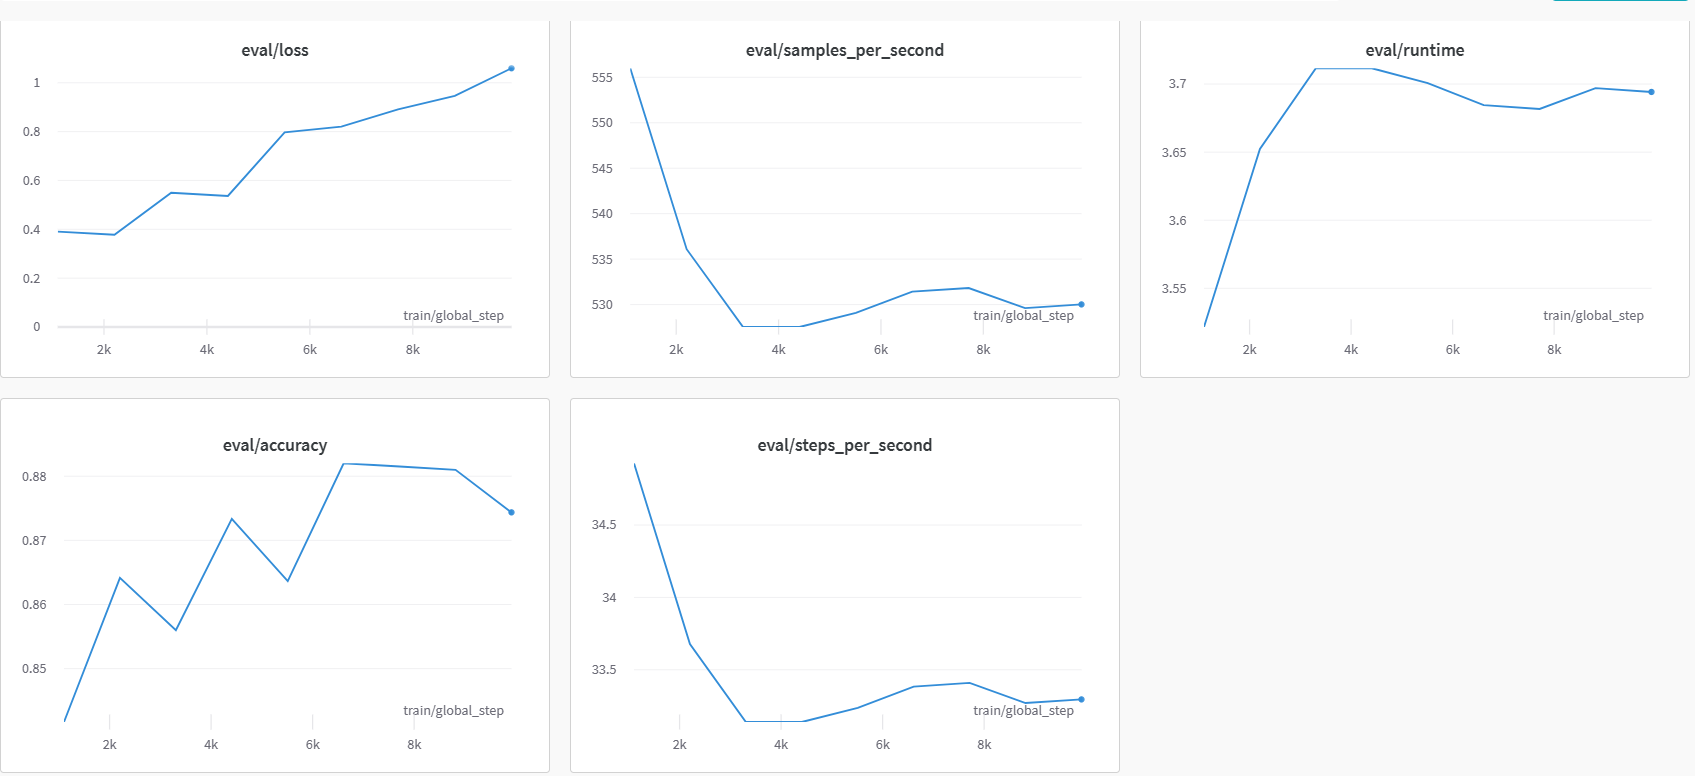
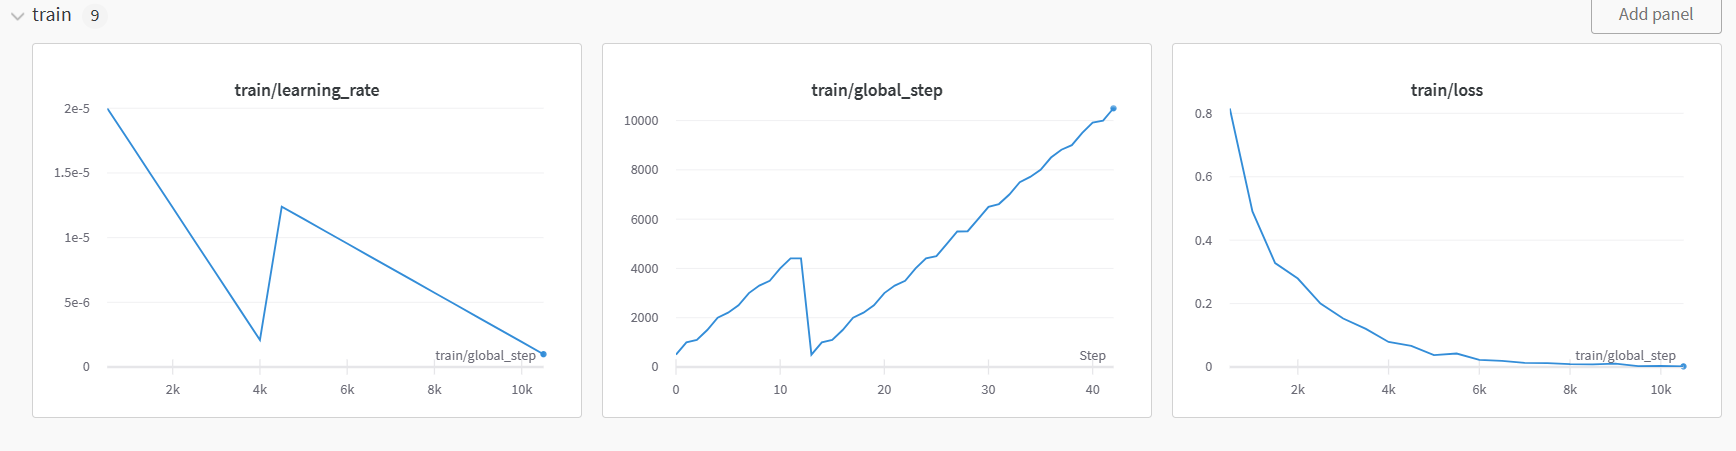

# Try different Model: BERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def preprocess_function(train_df):
    tokenized_output = tokenizer(train_df["text"], truncation=True)

    return {
        'input_ids': tokenized_output['input_ids'],
        'attention_mask': tokenized_output['attention_mask'],
        'labels': train_df["author_label"]
    }

In [ ]:
tokened_dictionary = SpookyTrain.apply(preprocess_function, axis=1, result_type = 'expand')
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(tokened_dictionary, test_size=0.1, stratify=SpookyTrain["author"],random_state=42) #due to we want to have 10 cross vals
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./HuggingFace_SavedModel/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="wandb",
    run_name="BERT_lr2emin5_epoch10_batch16",  # Name of the wandb run
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [69]:
trainer.train()

  5%|▍         | 500/11020 [04:09<2:19:47,  1.25it/s] 

{'loss': 0.5662, 'learning_rate': 2e-05, 'epoch': 0.45}


  9%|▉         | 1000/11020 [08:38<1:24:39,  1.97it/s]

{'loss': 0.4516, 'learning_rate': 1.9049429657794677e-05, 'epoch': 0.91}


 10%|█         | 1102/11020 [09:49<1:15:35,  2.19it/s]

{'eval_loss': 0.39219480752944946, 'eval_accuracy': 0.8508682328907048, 'eval_runtime': 16.941, 'eval_samples_per_second': 115.577, 'eval_steps_per_second': 7.26, 'epoch': 1.0}


 14%|█▎        | 1500/11020 [13:50<1:23:02,  1.91it/s] 

{'loss': 0.2709, 'learning_rate': 1.8098859315589353e-05, 'epoch': 1.36}


 18%|█▊        | 2000/11020 [18:32<1:32:18,  1.63it/s]

{'loss': 0.2293, 'learning_rate': 1.7148288973384032e-05, 'epoch': 1.81}


 20%|██        | 2204/11020 [21:05<1:03:58,  2.30it/s]

{'eval_loss': 0.3802695572376251, 'eval_accuracy': 0.8784473953013279, 'eval_runtime': 16.6585, 'eval_samples_per_second': 117.538, 'eval_steps_per_second': 7.384, 'epoch': 2.0}


 23%|██▎       | 2500/11020 [24:05<59:31,  2.39it/s]   

{'loss': 0.1568, 'learning_rate': 1.6197718631178708e-05, 'epoch': 2.27}


 27%|██▋       | 3000/11020 [28:43<1:41:49,  1.31it/s]

{'loss': 0.1082, 'learning_rate': 1.5247148288973386e-05, 'epoch': 2.72}


 30%|███       | 3306/11020 [31:41<56:08,  2.29it/s]

{'eval_loss': 0.6255951523780823, 'eval_accuracy': 0.8718079673135853, 'eval_runtime': 9.4105, 'eval_samples_per_second': 208.066, 'eval_steps_per_second': 13.071, 'epoch': 3.0}


 32%|███▏      | 3501/11020 [33:23<1:04:53,  1.93it/s]

{'loss': 0.0896, 'learning_rate': 1.4296577946768061e-05, 'epoch': 3.18}


 36%|███▋      | 4000/11020 [37:36<48:21,  2.42it/s]  

{'loss': 0.0599, 'learning_rate': 1.3346007604562739e-05, 'epoch': 3.63}


 40%|████      | 4408/11020 [41:16<43:44,  2.52it/s]

{'eval_loss': 0.736356258392334, 'eval_accuracy': 0.8907048008171604, 'eval_runtime': 9.4806, 'eval_samples_per_second': 206.526, 'eval_steps_per_second': 12.974, 'epoch': 4.0}


 41%|████      | 4501/11020 [42:09<41:33,  2.61it/s]  

{'loss': 0.0494, 'learning_rate': 1.2395437262357415e-05, 'epoch': 4.08}


 45%|████▍     | 4949/11020 [46:01<47:55,  2.11it/s]  

KeyboardInterrupt: 

As performance is actually similar to that of DistillBERT (only different around 1%), but the training time is drastically long, I am choosing the DistillBERT. Or For future reference we might take BERT but cut the operation at 2 epochs

In [ ]:
def model_name(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=3, id2label=id2label, label2id=label2id
    )
    
    return "BERT_lr2emin5_epoch10_batch16"

# Try models with similar complexity as BERT, but with stronger variation (XLNet)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("XLNet")

OSError: XLNet is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

# Try models with similar complexity as BERT, but with stronger variation (RoBERTa)

# Inference Steps

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "HuggingFace_SavedModel/DistillBERT_Finetuned/", num_labels=3, id2label=id2label, label2id=label2id
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HuggingFace_SavedModel/DistillBERT_Tokenizer/")

In [ ]:
results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")
print(results)

We reach 0.87 on Eval, try increasing it higher by training using the stopwords removal